## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def store_image(img, img_dir, fname):
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    img_path = img_dir + fname.split('/')[-1]
    cv2.imwrite(img_path, img)
        
def calibrate_camera():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #store every images with detected corners for post analyse and writeup
            img_dir = 'output_images/chessboard_corners/'
            img_path = img_dir + fname.split('/')[-1]
            store_image(img, img_dir, img_path)
    #calibrate camera with identified objpoints and imgpoints
    img_size = (img.shape[1], img.shape[0])
    return cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(150, 255), sx_thresh=(20, 200),l_thresh=(50,255)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    return  combined_binary

def warp(img,src2dst=True):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[585, 460],[203, 720],[1127, 720],[695, 460]])
    dst = np.float32([[320, 0],[320, 720],[960, 720],[960, 0]])
    #print(src, dst)
    
    if src2dst:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    return warped

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255,0,0),5)    

# Calibrate camera

In [5]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera()

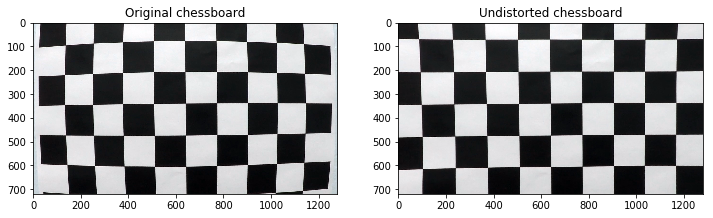

In [6]:
#test on chess board
cb = cv2.imread('camera_cal/calibration1.jpg')
undist_cb = undistort(cb)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(cb)
plt.title("Original chessboard")
plt.subplot(2, 2, 2)
plt.imshow(undist_cb)
plt.title("Undistorted chessboard")

plt.savefig('output_images/undistorted_cb.jpg')

## Test pipeline on test images and store output

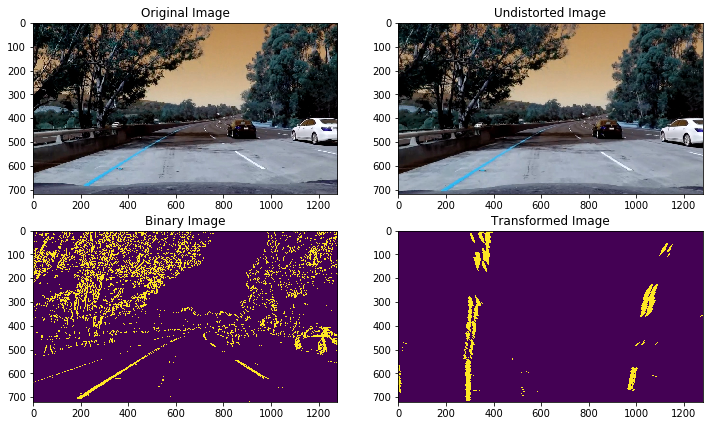

In [7]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

def preprocess_img(img):
    undist_img = undistort(img)
    binary_image = pipeline(undist_img)
    transformed = warp(binary_image)
    return transformed

# process test images
for fname in images:
    img = cv2.imread(fname)
    undist_img = undistort(img)
    store_image(undist_img, 'output_images/undistorted/', fname)
    binary_image = pipeline(undist_img)
    store_image(binary_image*255, 'output_images/binary_images/', fname)
    transformed = warp(binary_image)
    store_image(transformed*255, 'output_images/transformed_images/', fname)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(2, 2, 2)
plt.imshow(undist_img)
plt.title("Undistorted Image")
plt.subplot(2, 2, 3)
plt.imshow(binary_image*255)
plt.title("Binary Image")
plt.subplot(2, 2, 4)
plt.imshow(transformed*255)
plt.title("Transformed Image")

In [101]:
def detect_start(binary_warped, LL, RL, fname=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #plot
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    LL.update_params(left_fit, right_fit, leftx, lefty, ploty)
    RL.update_params(right_fit, left_fit, rightx, righty, ploty)
    
    if(fname!=None):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.savefig(fname)

#next frame fit poly
def detect_next(binary_warped, LL, RL):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] - margin)) & (nonzerox < (LL.current_fit[0]*(nonzeroy**2) + LL.current_fit[1]*nonzeroy + LL.current_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] - margin)) & (nonzerox < (RL.current_fit[0]*(nonzeroy**2) + RL.current_fit[1]*nonzeroy + RL.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    LL.update_params(left_fit, right_fit, leftx, lefty, ploty)
    RL.update_params(right_fit, left_fit, rightx, righty, ploty)
        

def calculate_curverad(leftx, rightx, ploty):
    # Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    #print(y_eval)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print('left:', left_curverad, 'm', 'right:', right_curverad, 'm')
    return left_curverad, right_curverad

def calculate_position(pts_left, pts_right):
    # 10th value for x 
    lane_middle = int((pts_right[0][10][0] - pts_left[0][10][0])/2.)+pts_left[0][10][0]
    #lane_middle = int((pts_right[10] - pts_left[10])/2.)+pts_left[10]
    
    if (lane_middle-640 > 0):
        leng = 3.66/2
        mag = ((lane_middle-640)/640.*leng)
        #head = ("Right",mag)
        return "Right", mag
    else:
        leng = 3.66/2.
        mag = ((lane_middle-640)/640.*leng)*-1
        #head = ("Left",mag)
        return "Left", mag
    
def line_base_pos(current_fit, ploty):
    y_eval = np.max(ploty)
    center_pos = 640
    line_pos = current_fit[0]*y_eval**2 + current_fit[1]*y_eval + current_fit[2]
    line_base_pos = (line_pos - center_pos)*3.7/600.0 #3.7 meters is about 600 pixels in the x direction
    
    # avoid negative distances, which would be the case for left lane
    # there is sure an more elegant way to handle this
    if line_base_pos < 0:
        line_base_pos *= (-1.0)
        
    return line_base_pos

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, name='ABC'):
        #Line name
        self.line_name = name
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #store detection miss here
        self.detection_miss = 0
        #rejection counter
        self.reject_counter = 0
    
    #check against big radius number doesn't make sense 
    #since in case of straight line it becomes very big
    #mr - my radius, otr - other radius
    def radius_in_range(self, mr, otr):
        result = False
        #radius check, reject too small radius
        if mr > 100: #200
            #check difference btw. two radius
            rd = np.abs(mr-otr)
            if rd < 60000:
                result = True
            else:
                print('Radius difference ', rd, ' not plauible -> reject line')
        else:
            print('Radius ', (mr), ' not plauible -> reject line')
        
        return result
    
    #mp - my position, otp - other position
    def position_in_range(self, mp, otp):
        result = False
        lane_width = 3.7    #in m
        max_tolerance = 0.5 # +/- tolerance in m
        #check lane width
        if (mp + otp) < lane_width + max_tolerance and (mp + otp) > lane_width - max_tolerance:
            
            result = (mp > ((lane_width / 2) - max_tolerance) and \
                     mp < ((lane_width / 2) + max_tolerance))
            
            if result == False:
                print('Line tolerance check for ', (mp), ' failed -> reject line')
        else:
            print('Lane width ', (mp+otp), ' not plauible -> reject line')
        return result
    
    #use both fits to have more sanity checks possibilities
    def update_params(self, my_fit, other_fit, allx, ally, ploty):
        # sanity check of the incoming params
        my_fitx = my_fit[0]*ploty**2 + my_fit[1]*ploty + my_fit[2]
        other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
        
        mr, otr = calculate_curverad(my_fitx, other_fitx, ploty)
        mp = line_base_pos (my_fit, ploty)
        otp = line_base_pos (other_fit, ploty)
        
        if self.radius_in_range(mr, otr) and self.position_in_range(mp, otp):
            self.detection_miss = 0
            self.detected = True
            self.recent_xfitted = my_fitx
            self.current_fit = my_fit
            self.radius_of_curvature = mr
            self.line_base_pos = mp
            self.allx = allx
            self.ally = ally
        else: # in case a miss increase the counter
            self.detection_miss +=1
            self.reject_counter +=1
            print(self.detection_miss, ' detections missed')
            if self.detection_miss >= 2:
                print(self.detection_miss, ' detections missed -> new detection cycle')
                self.detection_miss=0
                self.detected = False
                

In [102]:
# draw final lane on the original undistorted image
# add radius and distance information to every image
def draw_lane(undist, warped, LL, RL, fname=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([LL.recent_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([RL.recent_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, False) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #put radius and distance info on image
    color = (255,255,255)
    font = cv2.FONT_HERSHEY_SIMPLEX
        
    pos_rad_text = (50,50)
    pos_dis_text = (50,150)
    
    #Calcuate lane radius as a mean of both lines
    l = round(LL.radius_of_curvature, 2)
    r = round(RL.radius_of_curvature, 2)
    medianr = round((l+r)/2, 2)
    
    #Calcuate vehicle position
    posstr, pos = calculate_position(pts_left, pts_right)
    
    mrad = str('Lane curvature: ' + str(medianr) + 'm')
    offc = str('Vehicle is ' + str(round(pos,2)) + 'm' + ' ' + posstr + ' ' + 'of center')
    
    cv2.putText(result, mrad, pos_rad_text, font, 2, color, 2, cv2.LINE_AA)
    cv2.putText(result, offc, pos_dis_text, font, 2, color, 2, cv2.LINE_AA)
    
    if fname!=None:
        plt.savefig(fname)
    
    return result

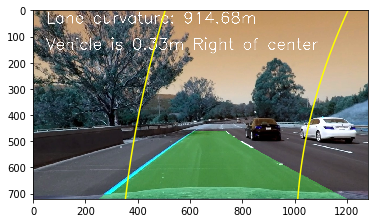

In [103]:
# process test images
#for fname in images:
L = Line('Left')
R = Line('Right')

img = cv2.imread('test_images/test6.jpg')

undist = undistort(img)
prep_img = preprocess_img(img)
detect_start(prep_img, L, R, 'output_images/left_fitx_right_fitx.jpg')

#print ('L ', L.recent_xfitted)
#print ('R ', R.recent_xfitted)

result = draw_lane(undist, prep_img, L,  R)
plt.imshow(result)
plt.savefig('output_images/test4_final_lane.jpg')

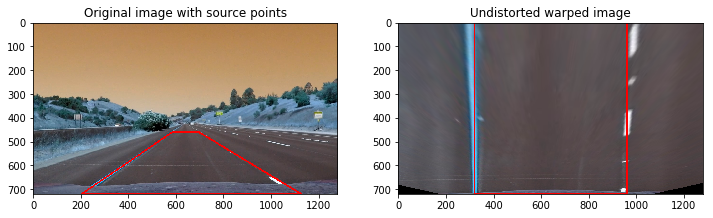

In [104]:
img2 = cv2.imread('test_images/straight_lines1.jpg')

shape = img2.shape

src = np.float32([[585, 460],[203, 720],[1127, 720],[695, 460]])
dst = np.float32([[320, 0],[320, 720],[960, 720],[960, 0]])

undist2 = undistort(img2)
warp2 = warp(undist2)

draw_lines(warp2, dst)
draw_lines(img2, src)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.imshow(img2)
plt.title("Original image with source points")
plt.subplot(2, 2, 2)
plt.imshow(warp2)
plt.title("Undistorted warped image")

plt.savefig('output_images/warped_undistorted.jpg')

In [105]:
def process_image(img):
    global LLine
    global RLine
    undist = undistort(img)
    prep_img = preprocess_img(img)
    if LLine.detected == False or RLine.detected == False:
        print('LL: ', LLine.detected, 'RL: ', RLine.detected, '-> start new detection cycle')
        detect_start(prep_img, LLine, RLine)
    else:
        detect_next(prep_img, LLine, RLine)
    result = draw_lane(undist, prep_img, LLine,  RLine)
    return result

In [ ]:
LLine = Line('L')
RLine = Line('R')

out_dir='./'
output = out_dir + 'processed_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(output, audio=False)
print(LLine.reject_counter, ' rejections for ', LLine.line_name)
print(RLine.reject_counter, ' rejections for ', RLine.line_name)

LL:  False RL:  False -> start new detection cycle
[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


  1%|          | 9/1261 [00:01<03:09,  6.59it/s]

Line tolerance check for  2.4993240446  failed -> reject line
1  detections missed
Line tolerance check for  2.50328845814  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


  1%|          | 11/1261 [00:01<03:14,  6.43it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.44479913998  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle


  2%|▏         | 23/1261 [00:03<03:25,  6.04it/s]

Line tolerance check for  2.35255597249  failed -> reject line
1  detections missed


  3%|▎         | 35/1261 [00:05<03:12,  6.36it/s]

Line tolerance check for  2.4184310137  failed -> reject line
1  detections missed
Line tolerance check for  2.35139460315  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


  3%|▎         | 36/1261 [00:05<03:23,  6.01it/s]

LL:  True RL:  False -> start new detection cycle


  4%|▍         | 48/1261 [00:07<03:30,  5.77it/s]

Line tolerance check for  2.3768973618  failed -> reject line
1  detections missed


  5%|▍         | 59/1261 [00:09<03:31,  5.67it/s]

Line tolerance check for  2.36994772783  failed -> reject line
1  detections missed


 13%|█▎        | 160/1261 [00:25<02:47,  6.55it/s]

Line tolerance check for  2.39048734721  failed -> reject line
1  detections missed


 24%|██▍       | 306/1261 [00:49<02:25,  6.55it/s]

Line tolerance check for  2.39171789495  failed -> reject line
1  detections missed


 25%|██▍       | 315/1261 [00:50<02:27,  6.42it/s]

Radius difference  537278.426038  not plauible -> reject line
1  detections missed
Radius difference  537278.426038  not plauible -> reject line
1  detections missed


 25%|██▌       | 317/1261 [00:51<02:44,  5.73it/s]

Radius difference  87115.598997  not plauible -> reject line
1  detections missed
Radius difference  87115.598997  not plauible -> reject line
1  detections missed


 26%|██▌       | 331/1261 [00:53<02:26,  6.35it/s]

Radius difference  60892.9749204  not plauible -> reject line
1  detections missed
Radius difference  60892.9749204  not plauible -> reject line
1  detections missed


 27%|██▋       | 338/1261 [00:54<02:37,  5.84it/s]

Radius difference  435318.204016  not plauible -> reject line
1  detections missed
Radius difference  435318.204016  not plauible -> reject line
1  detections missed


 28%|██▊       | 352/1261 [00:56<02:21,  6.44it/s]

Radius difference  579210.264044  not plauible -> reject line
1  detections missed
Radius difference  579210.264044  not plauible -> reject line
1  detections missed


 29%|██▊       | 360/1261 [00:57<02:26,  6.14it/s]

Radius difference  152881.07216  not plauible -> reject line
1  detections missed
Radius difference  152881.07216  not plauible -> reject line
1  detections missed


 30%|██▉       | 375/1261 [01:00<02:34,  5.72it/s]

Radius difference  63788.0611395  not plauible -> reject line
1  detections missed
Radius difference  63788.0611395  not plauible -> reject line
1  detections missed


 31%|███       | 387/1261 [01:02<02:41,  5.40it/s]

Radius difference  168223.17251  not plauible -> reject line
1  detections missed
Radius difference  168223.17251  not plauible -> reject line
1  detections missed
Radius difference  163223.31879  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Radius difference  163223.31879  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 31%|███       | 389/1261 [01:03<02:55,  4.97it/s]

LL:  False RL:  False -> start new detection cycle
Radius difference  96566.1727295  not plauible -> reject line
1  detections missed
Radius difference  96566.1727295  not plauible -> reject line
1  detections missed


 32%|███▏      | 407/1261 [01:06<02:19,  6.13it/s]

Radius difference  67973.1935486  not plauible -> reject line
1  detections missed
Radius difference  67973.1935486  not plauible -> reject line
1  detections missed


 33%|███▎      | 415/1261 [01:07<02:22,  5.92it/s]

Radius difference  107147.378717  not plauible -> reject line
1  detections missed
Radius difference  107147.378717  not plauible -> reject line
1  detections missed


 34%|███▎      | 424/1261 [01:09<02:17,  6.07it/s]

Radius difference  75384.6643471  not plauible -> reject line
1  detections missed
Radius difference  75384.6643471  not plauible -> reject line
1  detections missed


 35%|███▍      | 441/1261 [01:11<02:10,  6.30it/s]

Radius difference  89820.2486798  not plauible -> reject line
1  detections missed
Radius difference  89820.2486798  not plauible -> reject line
1  detections missed


 35%|███▌      | 444/1261 [01:12<02:10,  6.25it/s]

Radius difference  105526.971057  not plauible -> reject line
1  detections missed
Radius difference  105526.971057  not plauible -> reject line
1  detections missed


 36%|███▌      | 456/1261 [01:14<02:10,  6.17it/s]

Radius difference  68068.7240452  not plauible -> reject line
1  detections missed
Radius difference  68068.7240452  not plauible -> reject line
1  detections missed


 37%|███▋      | 465/1261 [01:15<02:12,  6.01it/s]

Radius difference  369703.949662  not plauible -> reject line
1  detections missed
Radius difference  369703.949662  not plauible -> reject line
1  detections missed


 39%|███▊      | 488/1261 [01:19<02:06,  6.10it/s]

Radius difference  239791.733188  not plauible -> reject line
1  detections missed
Radius difference  239791.733188  not plauible -> reject line
1  detections missed
Radius difference  190916.955691  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Radius difference  190916.955691  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 39%|███▉      | 489/1261 [01:19<02:18,  5.56it/s]

LL:  False RL:  False -> start new detection cycle
Radius difference  180213.925259  not plauible -> reject line
1  detections missed
Radius difference  180213.925259  not plauible -> reject line
1  detections missed
LL:  False RL:  False -> start new detection cycle


 41%|████      | 513/1261 [01:23<02:02,  6.12it/s]

Radius difference  63375.6429587  not plauible -> reject line
1  detections missed
Radius difference  63375.6429587  not plauible -> reject line
1  detections missed


 41%|████      | 516/1261 [01:24<02:00,  6.19it/s]

Radius difference  254604.167327  not plauible -> reject line
1  detections missed
Radius difference  254604.167327  not plauible -> reject line
1  detections missed


 42%|████▏     | 527/1261 [01:25<01:55,  6.36it/s]

Radius difference  124431.384796  not plauible -> reject line
1  detections missed
Radius difference  124431.384796  not plauible -> reject line
1  detections missed


 42%|████▏     | 530/1261 [01:26<01:54,  6.36it/s]

Radius difference  115338.391505  not plauible -> reject line
1  detections missed
Radius difference  115338.391505  not plauible -> reject line
1  detections missed


 42%|████▏     | 534/1261 [01:27<02:05,  5.81it/s]

Lane width  3.15897830957  not plauible -> reject line
1  detections missed
Lane width  3.15897830957  not plauible -> reject line
1  detections missed


 43%|████▎     | 536/1261 [01:27<02:06,  5.73it/s]

Lane width  3.19097420138  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  3.19097420138  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 44%|████▍     | 557/1261 [01:30<01:52,  6.24it/s]

Radius difference  198359.953069  not plauible -> reject line
1  detections missed
Radius difference  198359.953069  not plauible -> reject line
1  detections missed


 45%|████▍     | 564/1261 [01:32<01:57,  5.93it/s]

Lane width  4.20838209476  not plauible -> reject line
1  detections missed
Lane width  4.20838209476  not plauible -> reject line
1  detections missed
Lane width  4.20108821402  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.20108821402  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 45%|████▍     | 566/1261 [01:32<01:53,  6.11it/s]

LL:  False RL:  False -> start new detection cycle


 47%|████▋     | 590/1261 [01:36<01:45,  6.36it/s]

Lane width  4.24549537755  not plauible -> reject line
1  detections missed
Lane width  4.24549537755  not plauible -> reject line
1  detections missed


 49%|████▊     | 612/1261 [01:39<01:49,  5.94it/s]

Lane width  4.20569659376  not plauible -> reject line
1  detections missed
Lane width  4.20569659376  not plauible -> reject line
1  detections missed
Lane width  4.21645700171  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.21645700171  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 49%|████▊     | 613/1261 [01:40<01:47,  6.02it/s]

LL:  False RL:  False -> start new detection cycle
Lane width  4.25606642976  not plauible -> reject line
1  detections missed
Lane width  4.25606642976  not plauible -> reject line
1  detections missed


 49%|████▉     | 615/1261 [01:40<01:48,  5.97it/s]

Lane width  4.24681081963  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.24681081963  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  False RL:  False -> start new detection cycle


 61%|██████▏   | 775/1261 [02:06<01:17,  6.25it/s]

Line tolerance check for  2.35203700252  failed -> reject line
1  detections missed
Line tolerance check for  2.37476145648  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 62%|██████▏   | 776/1261 [02:06<01:17,  6.22it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.46948098177  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.40065313313  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 62%|██████▏   | 778/1261 [02:06<01:20,  6.03it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.3791681476  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.39549624311  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 62%|██████▏   | 780/1261 [02:07<01:19,  6.08it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.40313608265  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.3946612601  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 62%|██████▏   | 782/1261 [02:07<01:24,  5.64it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.38063725031  failed -> reject line
1  detections missed


 62%|██████▏   | 783/1261 [02:07<01:29,  5.33it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.36913361552  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.37998054618  failed -> reject line
1  detections missed


 62%|██████▏   | 785/1261 [02:08<01:25,  5.56it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.38326033551  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  True RL:  False -> start new detection cycle


 62%|██████▏   | 786/1261 [02:08<01:28,  5.36it/s]

Line tolerance check for  2.38968075458  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle


 62%|██████▏   | 788/1261 [02:08<01:26,  5.45it/s]

Line tolerance check for  2.39987221651  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.5156765768  failed -> reject line
1  detections missed


 63%|██████▎   | 789/1261 [02:08<01:35,  4.95it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.44430880203  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle
LL:  True RL:  False -> start new detection cycle


 63%|██████▎   | 791/1261 [02:09<01:27,  5.37it/s]

Line tolerance check for  2.3772810234  failed -> reject line
1  detections missed
Line tolerance check for  2.35895182394  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 63%|██████▎   | 793/1261 [02:09<01:26,  5.40it/s]

LL:  True RL:  False -> start new detection cycle


 63%|██████▎   | 800/1261 [02:10<01:19,  5.81it/s]

Line tolerance check for  2.35101105996  failed -> reject line
1  detections missed
Line tolerance check for  2.39829573865  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 64%|██████▎   | 801/1261 [02:11<01:24,  5.42it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.38740801839  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle


 64%|██████▍   | 812/1261 [02:12<01:15,  5.97it/s]

Line tolerance check for  2.37908581885  failed -> reject line
1  detections missed
Line tolerance check for  2.48980506828  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 65%|██████▍   | 814/1261 [02:13<01:12,  6.18it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.48047178551  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.48039978185  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 65%|██████▍   | 815/1261 [02:13<01:13,  6.06it/s]

LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.37566983449  failed -> reject line
1  detections missed
LL:  True RL:  False -> start new detection cycle
Line tolerance check for  2.38041736031  failed -> reject line
2  detections missed
2  detections missed -> new detection cycle


 65%|██████▍   | 817/1261 [02:13<01:14,  5.93it/s]

LL:  True RL:  False -> start new detection cycle


 79%|███████▊  | 990/1261 [02:41<00:43,  6.16it/s]

Line tolerance check for  2.35042690621  failed -> reject line
1  detections missed


 80%|███████▉  | 1006/1261 [02:44<00:42,  5.99it/s]

Lane width  4.2045741145  not plauible -> reject line
1  detections missed
Lane width  4.2045741145  not plauible -> reject line
1  detections missed


 82%|████████▏ | 1034/1261 [02:48<00:36,  6.14it/s]

Lane width  4.20788257488  not plauible -> reject line
1  detections missed
Lane width  4.20788257488  not plauible -> reject line
1  detections missed
Lane width  4.20774963206  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.20774963206  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 82%|████████▏ | 1036/1261 [02:49<00:41,  5.48it/s]

LL:  False RL:  False -> start new detection cycle


 82%|████████▏ | 1039/1261 [02:49<00:37,  5.92it/s]

Lane width  4.27023561925  not plauible -> reject line
1  detections missed
Lane width  4.27023561925  not plauible -> reject line
1  detections missed


 84%|████████▎ | 1053/1261 [02:52<00:34,  5.95it/s]

Lane width  4.20498612433  not plauible -> reject line
1  detections missed
Lane width  4.20498612433  not plauible -> reject line
1  detections missed
Lane width  4.2517540339  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle
Lane width  4.2517540339  not plauible -> reject line
2  detections missed
2  detections missed -> new detection cycle


 84%|████████▎ | 1055/1261 [02:52<00:33,  6.15it/s]

LL:  False RL:  False -> start new detection cycle


 96%|█████████▌| 1208/1261 [03:17<00:08,  6.27it/s]